# Problem Statement
The goal of this project is to detect fraudulent financial transactions using machine learning. The dataset contains customer transactions with features such as transaction type, amount, old and new account balances, and flags indicating fraudulent activity.

The objective is to:
- Understand patterns in fraudulent vs. non-fraudulent transactions
- Engineer new meaningful features
- Handle class imbalance (fraud is only ~10%)
- Build a machine learning model to accurately classify fraud
- Evaluate using precision, recall, F1-score, ROC-AUC

#  Load & Inspect Data

In [1]:
import pandas as pd 
import numpy as np
df = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\BIA\Fraud_Detection\Fraud_Analysis_Dataset.csv')

print('Shape:', df.shape)
df.head()

Shape: (11142, 10)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,11142.000000,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,1.114200e+04,11142.000000
mean,8.717645,2.131915e+05,9.241173e+05,8.249576e+05,8.883541e+05,1.103211e+06,0.102495
std,16.067479,7.600650e+05,2.143004e+06,2.089894e+06,2.601376e+06,2.982447e+06,0.303312
min,1.000000,2.390000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.000000,4.946618e+03,4.270000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,6.000000,1.676126e+04,2.816950e+04,4.420605e+03,0.000000e+00,0.000000e+00,0.000000
75%,7.000000,1.543366e+05,3.040855e+05,1.114126e+05,2.711555e+05,3.186374e+05,0.000000
max,95.000000,1.000000e+07,1.990000e+07,1.300000e+07,3.300000e+07,3.460000e+07,1.000000


In [4]:
print(df['isFraud'].value_counts())
print('\nClass ratio (normalized):')
print(df['isFraud'].value_counts(normalize=True))

isFraud
0    10000
1     1142
Name: count, dtype: int64

Class ratio (normalized):
isFraud
0    0.897505
1    0.102495
Name: proportion, dtype: float64


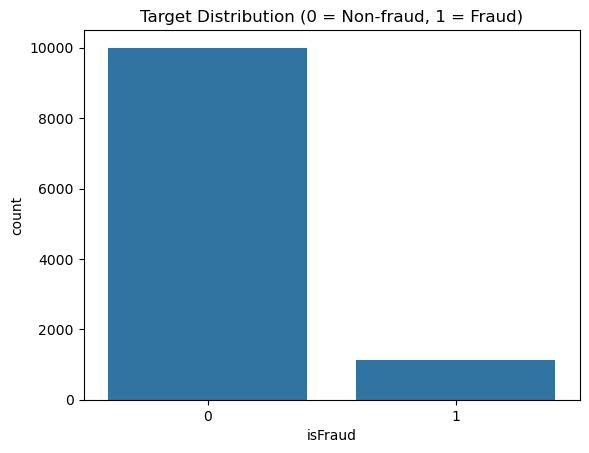

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='isFraud', data=df)
plt.title('Target Distribution (0 = Non-fraud, 1 = Fraud)')
plt.show()

# Exploratory Data Analysis (EDA)

In [6]:
df['type'].value_counts()


type
PAYMENT     5510
CASH_IN     1951
CASH_OUT    1871
TRANSFER    1464
DEBIT        346
Name: count, dtype: int64

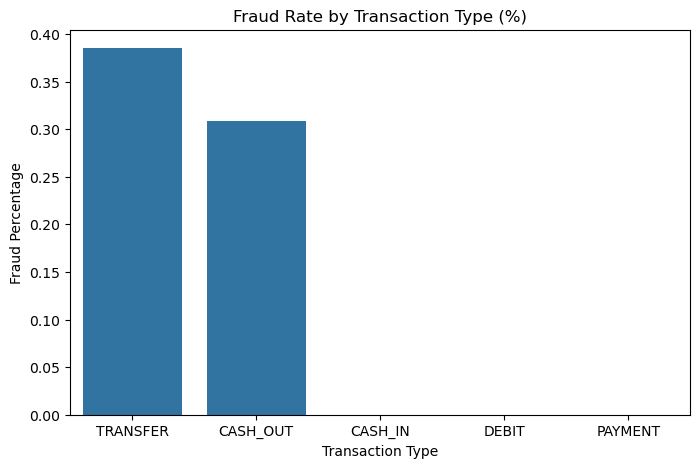

type
TRANSFER    0.385246
CASH_OUT    0.308926
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [7]:
type_fraud = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=type_fraud.index, y=type_fraud.values)
plt.title("Fraud Rate by Transaction Type (%)")
plt.ylabel("Fraud Percentage")
plt.xlabel("Transaction Type")
plt.show()

type_fraud



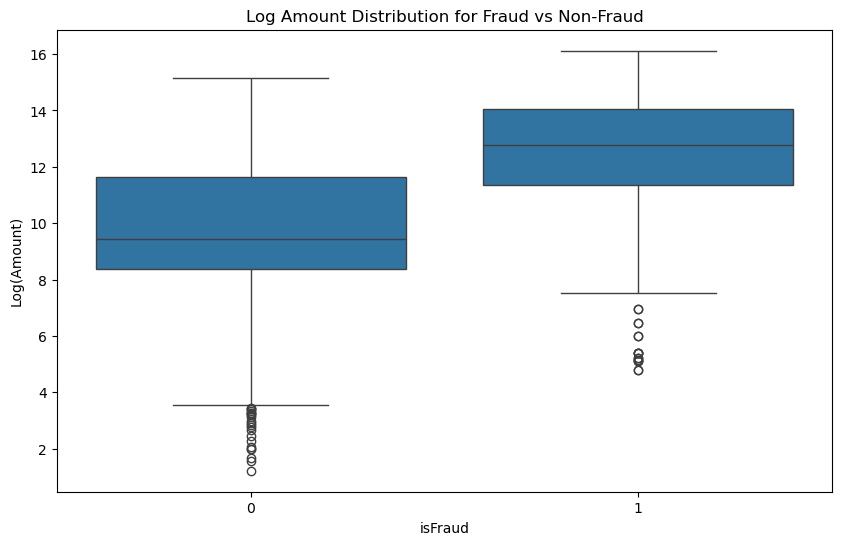

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='isFraud', y=np.log1p(df['amount']))
plt.title("Log Amount Distribution for Fraud vs Non-Fraud")
plt.xlabel("isFraud")
plt.ylabel("Log(Amount)")
plt.show()


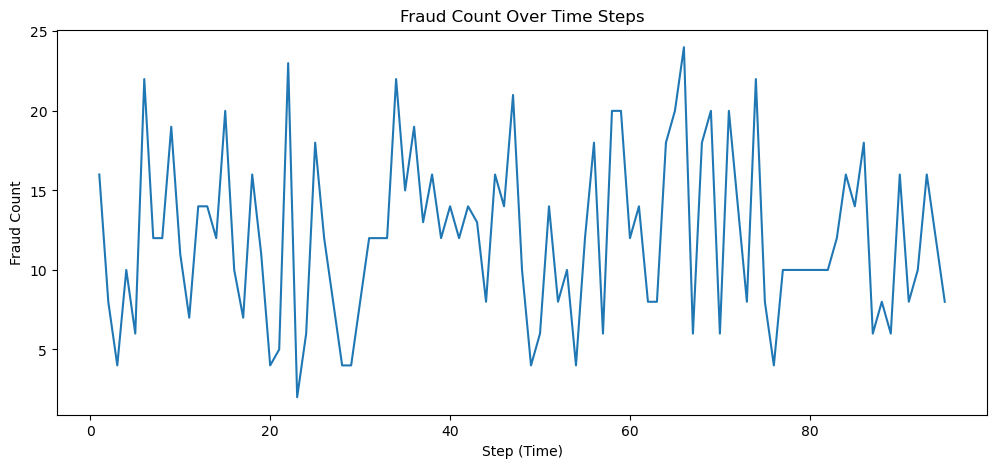

In [9]:
plt.figure(figsize=(12,5))
fraud_steps = df[df['isFraud']==1]['step'].value_counts().sort_index()

plt.plot(fraud_steps.index, fraud_steps.values)
plt.title("Fraud Count Over Time Steps")
plt.xlabel("Step (Time)")
plt.ylabel("Fraud Count")
plt.show()


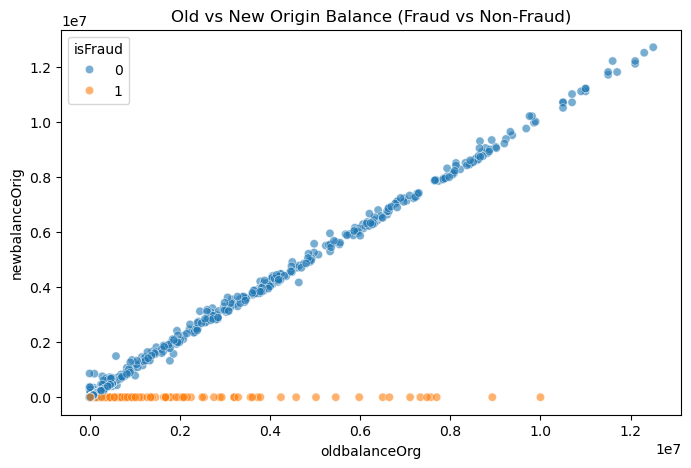

In [10]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df.sample(2000, random_state=42), 
    x='oldbalanceOrg', 
    y='newbalanceOrig', 
    hue='isFraud',
    alpha=0.6
)
plt.title("Old vs New Origin Balance (Fraud vs Non-Fraud)")
plt.show()



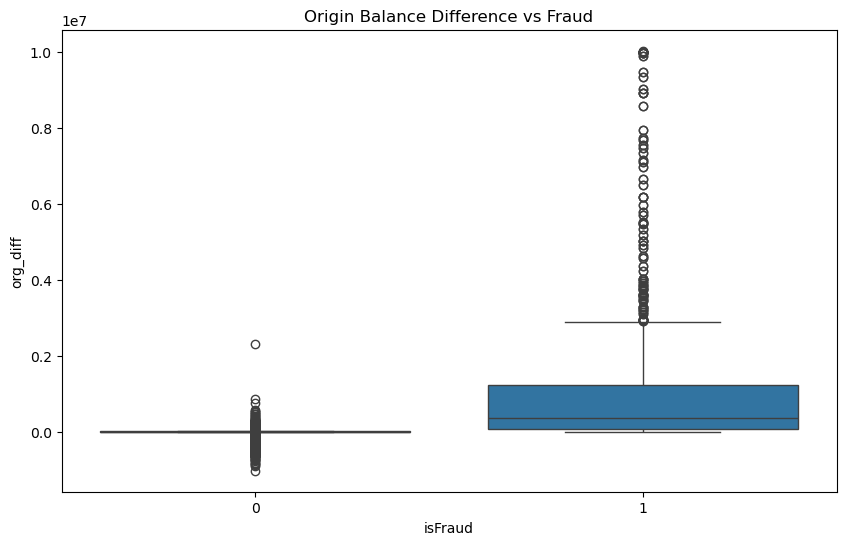

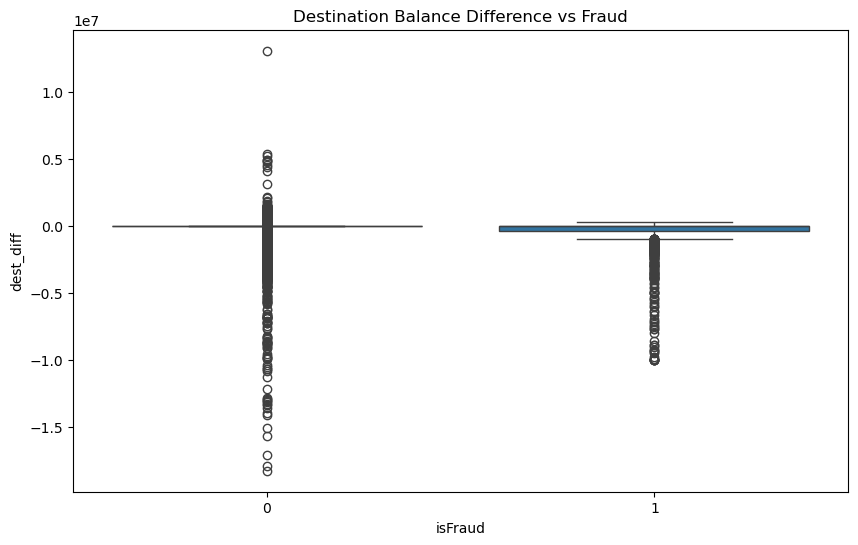

In [11]:
df['org_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_diff'] = df['oldbalanceDest'] - df['newbalanceDest']

plt.figure(figsize=(10,6))
sns.boxplot(x=df['isFraud'], y=df['org_diff'])
plt.title("Origin Balance Difference vs Fraud")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['isFraud'], y=df['dest_diff'])
plt.title("Destination Balance Difference vs Fraud")
plt.show()


In [12]:
df['zero_origin'] = (df['oldbalanceOrg']==0).astype(int)
df['zero_dest'] = (df['oldbalanceDest']==0).astype(int)

zero_pattern = df[['zero_origin','zero_dest','isFraud']].groupby(['zero_origin','zero_dest']).mean()

zero_pattern.style.background_gradient(cmap='Reds')


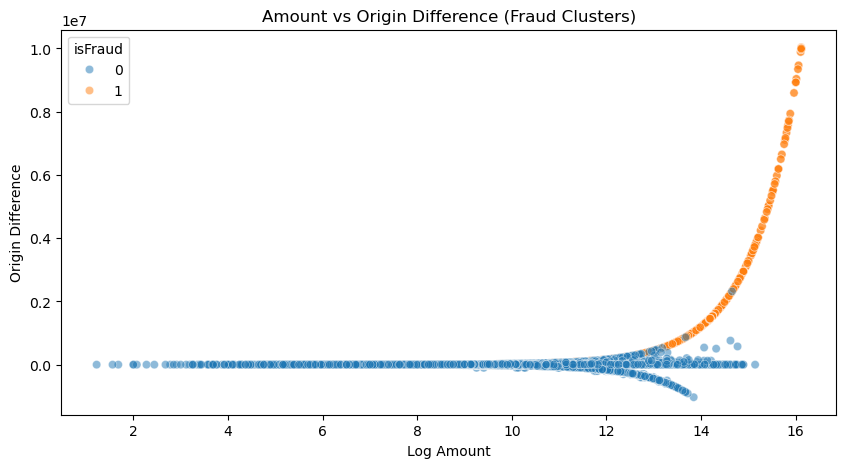

In [13]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=df.sample(2000, random_state=42),
    x=np.log1p(df['amount']),
    y=df['org_diff'],
    hue=df['isFraud'],
    alpha=0.5
)
plt.title("Amount vs Origin Difference (Fraud Clusters)")
plt.xlabel("Log Amount")
plt.ylabel("Origin Difference")
plt.show()


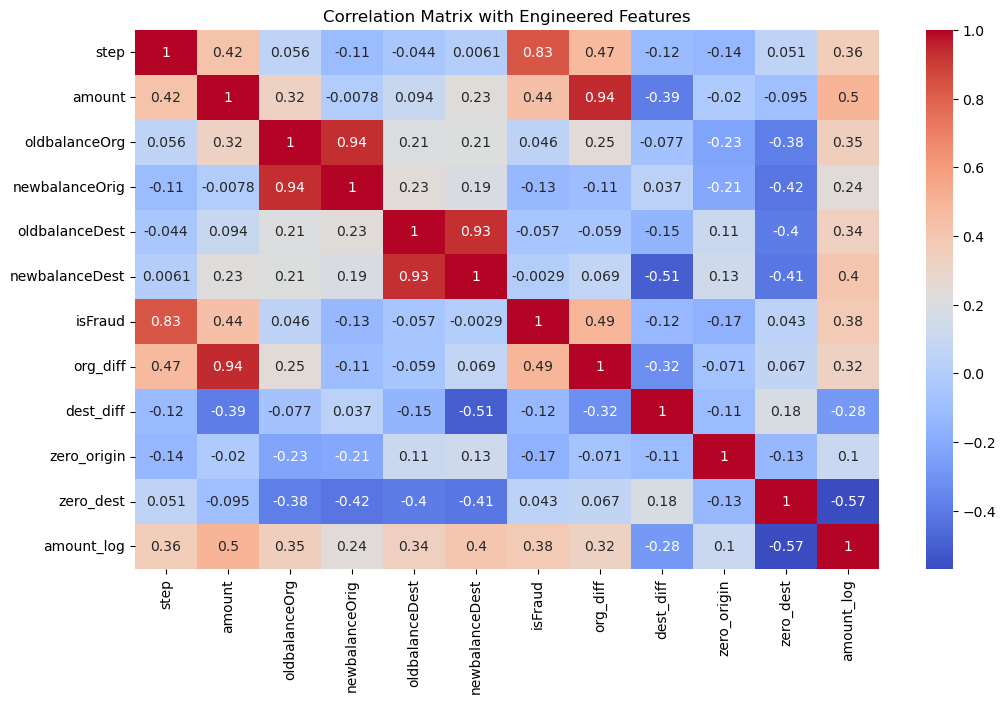

In [14]:
df_corr = df.copy()
df_corr['amount_log'] = np.log1p(df_corr['amount'])
df_corr['org_diff'] = df_corr['oldbalanceOrg'] - df_corr['newbalanceOrig']
df_corr['dest_diff'] = df_corr['oldbalanceDest'] - df_corr['newbalanceDest']

num_cols = df_corr.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12,7))
sns.heatmap(df_corr[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix with Engineered Features")
plt.show()


# Feature Engineering

In [15]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    """Create model-ready features from raw transaction data."""
    df_fe = data.copy()

    for col in ['nameOrig', 'nameDest']:
        if col in df_fe.columns:
            df_fe = df_fe.drop(columns=[col])

    
    if 'amount' in df_fe.columns:
        df_fe['amount_log'] = np.log1p(df_fe['amount'])

    if {'oldbalanceOrg', 'newbalanceOrig'} <= set(df_fe.columns):
        df_fe['org_diff'] = df_fe['oldbalanceOrg'] - df_fe['newbalanceOrig']
    if {'oldbalanceDest', 'newbalanceDest'} <= set(df_fe.columns):
        df_fe['dest_diff'] = df_fe['oldbalanceDest'] - df_fe['newbalanceDest']

    
    df_fe['is_orig_zero_before'] = (df_fe['oldbalanceOrg'] == 0).astype(int)
    df_fe['is_dest_zero_before'] = (df_fe['oldbalanceDest'] == 0).astype(int)

    if 'type' in df_fe.columns:
        df_fe = pd.get_dummies(df_fe, columns=['type'], drop_first=True)

    return df_fe

df_fe = feature_engineering(df)
print('After feature engineering:', df_fe.shape)
df_fe.head()

After feature engineering: (11142, 18)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,org_diff,dest_diff,zero_origin,zero_dest,amount_log,is_orig_zero_before,is_dest_zero_before,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,181.0,181.0,0.0,0.0,0.0,1,181.0,0.0,0,1,5.204007,0,1,False,False,False,True
1,1,181.0,181.0,0.0,21182.0,0.0,1,181.0,21182.0,0,0,5.204007,0,0,True,False,False,False
2,1,2806.0,2806.0,0.0,0.0,0.0,1,2806.0,0.0,0,1,7.939872,0,1,False,False,False,True
3,1,2806.0,2806.0,0.0,26202.0,0.0,1,2806.0,26202.0,0,0,7.939872,0,0,True,False,False,False
4,1,20128.0,20128.0,0.0,0.0,0.0,1,20128.0,0.0,0,1,9.909917,0,1,False,False,False,True


# Train–Test Split

In [16]:
from sklearn.model_selection import train_test_split
TARGET_COL = 'isFraud'

X = df_fe.drop(columns=[TARGET_COL])
y = df_fe[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('Train class distribution:\n', y_train.value_counts(normalize=True))

X_train: (8913, 17) X_test: (2229, 17)
Train class distribution:
 isFraud
0    0.897453
1    0.102547
Name: proportion, dtype: float64


# Smote

In [22]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("\nAfter SMOTE:", y_train_res.value_counts())


Before SMOTE: isFraud
0    7999
1     914
Name: count, dtype: int64

After SMOTE: isFraud
0    7999
1    7999
Name: count, dtype: int64


# Model Training & Evaluation

In [37]:
def evaluate_model(y_true, y_pred, y_proba, model_name='Model'):
    print(f"\n {model_name} Evaluation")
    print('Classification Report:\n', classification_report(y_true, y_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
    

    try:
        roc = roc_auc_score(y_true, y_proba)
        pr_auc = average_precision_score(y_true, y_proba)
        print(f'ROC-AUC: {roc:.4f}')
        print(f'PR-AUC : {pr_auc:.4f}')
    except Exception as e:
        print('Could not compute ROC/PR AUC:', e)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

log_reg.fit(X_train_res, y_train_res)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_lr, y_proba_lr, model_name='Logistic Regression')




 Logistic Regression Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2001
           1       0.98      0.95      0.96       228

    accuracy                           0.99      2229
   macro avg       0.99      0.97      0.98      2229
weighted avg       0.99      0.99      0.99      2229

Confusion Matrix:
 [[1996    5]
 [  11  217]]
ROC-AUC: 0.9926
PR-AUC : 0.9877


In [39]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

rf_clf.fit(X_train_res, y_train_res)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_rf, y_proba_rf, model_name='Random Forest')


 Random Forest Evaluation
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       1.00      0.99      0.99       228

    accuracy                           1.00      2229
   macro avg       1.00      0.99      1.00      2229
weighted avg       1.00      1.00      1.00      2229

Confusion Matrix:
 [[2000    1]
 [   3  225]]
ROC-AUC: 1.0000
PR-AUC : 0.9996


In [40]:
from xgboost import XGBClassifier

scale_pos = y_train_res.value_counts()[0] / y_train_res.value_counts()[1]

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=scale_pos,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
print(" XGBoost Evaluation ")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

print("ROC-AUC :", roc_auc_score(y_test, y_proba_xgb))
print("PR-AUC  :", average_precision_score(y_test, y_proba_xgb))



 XGBoost Evaluation 
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       0.99      1.00      0.99       228

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229

Confusion Matrix:
 [[1999    2]
 [   1  227]]
ROC-AUC : 0.9999386271776391
PR-AUC  : 0.9994948402956313


In [41]:
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)

def get_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    return {
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "PR-AUC": average_precision_score(y_test, y_proba)
    }

results = {
    "Logistic Regression": get_scores(log_reg, X_test, y_test),
    "Random Forest": get_scores(rf_clf, X_test, y_test),
    "XGBoost": get_scores(xgb_clf, X_test, y_test)
}

comparison_df = pd.DataFrame(results).T
comparison_df
comparison_df.style.highlight_max(color='lightgreen')


,Precision,Recall,F1-Score,ROC-AUC,PR-AUC
Logistic Regression,0.977477,0.951754,0.964444,0.992552,0.987726
Random Forest,0.995575,0.986842,0.991189,0.999958,0.999647
XGBoost,0.991266,0.995614,0.993435,0.999939,0.999495


# SHAP Explainability (with Tree-based Model)

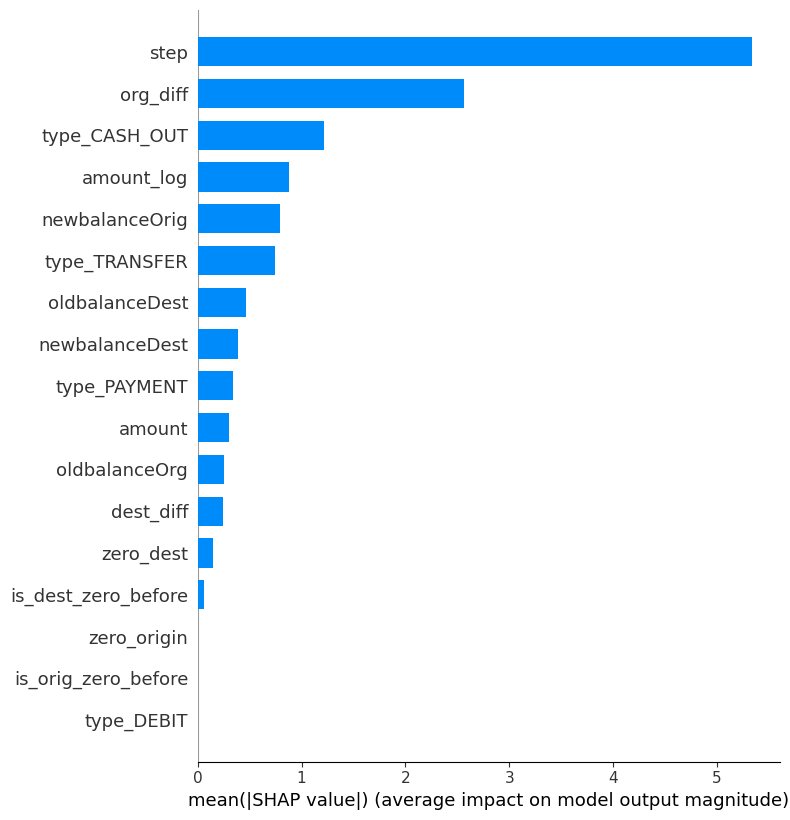

In [42]:
import shap

explainer = shap.TreeExplainer(xgb_clf)    

X_sample = X_train_res.sample(2000, random_state=42)

shap_values = explainer.shap_values(X_sample)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]   
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_sample, plot_type="bar")


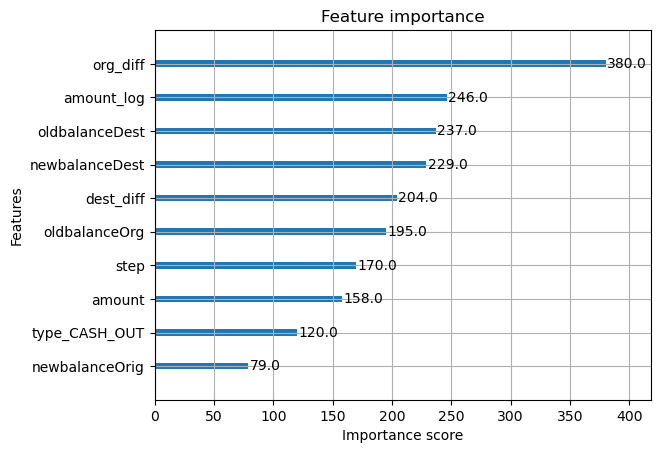

In [43]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_clf, max_num_features=10)
plt.show()


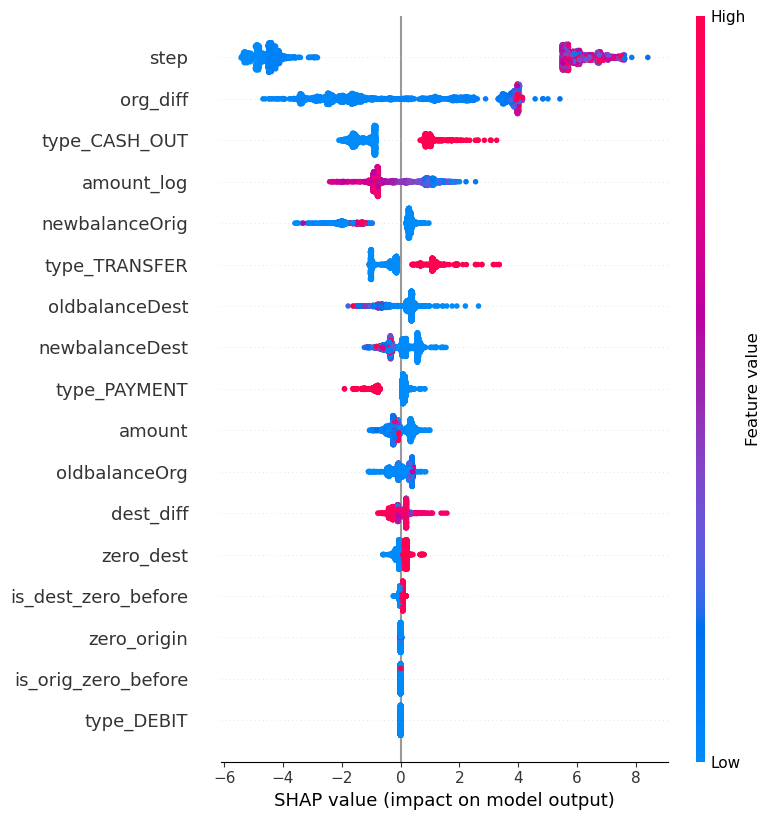

In [44]:
shap.summary_plot(shap_values, X_sample, plot_type='dot')

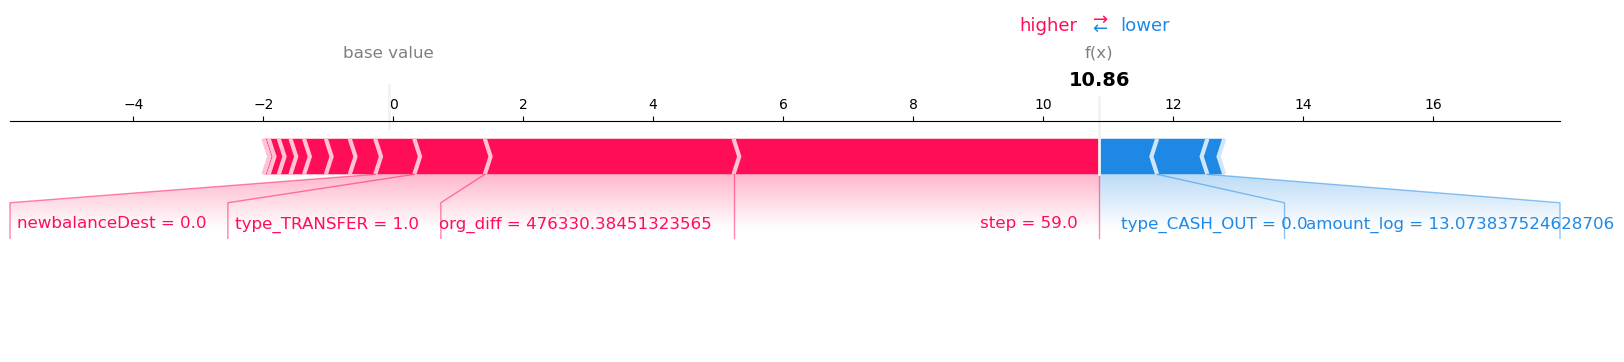

In [45]:
index = 0
shap.force_plot(
    explainer.expected_value,
    shap_values[index],
    X_sample.iloc[index, :],
    matplotlib=True
)

